# Investigating the Practicality of Adversarial Evasion Attacks on Network Intrusion Detection (NSL-KDD)

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import copy
import time as time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2

#!pip install adversarial-robustness-toolbox >/dev/null
import os,sys
sys.path.append(os.path.dirname('../adversarial-robustness-toolbox/'))
from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, DeepFool, SaliencyMapMethod, CarliniL2Method, CarliniLInfMethod, CarliniL0Method
from art.classifiers import PyTorchClassifier

%matplotlib inline

pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

## Data pre-processing

### Download and import the dataset

In [2]:
# Download and extract the dataset if it doesn't exist
!if [ ! -d "../NSL-KDD" ]; then wget http://205.174.165.80/CICDataset/NSL-KDD/Dataset/NSL-KDD.zip; mkdir ../NSL-KDD; unzip NSL-KDD.zip -d ../NSL-KDD; fi
    
# Import the training and testing datasets from .CSV to Pandas DataFrames
features = ['1 Duration', '2 Protocol-type : ', '3 Service : ', '4 Flag : ', '5 Src-bytes', '6 Dst-bytes', '7 Land', '8 Wrong-fragment', '9 Urgent', '10 Hot', '11 Num-failed-logins', '12 Logged-in', '13 Num-compromised', '14 Root-shell', '15 Su-attempted', '16 Num-root', '17 Num-file-creations', '18 Num-shells', '19 Num-access-files', '20 Num-outbound-cmds', '21 Is-host-login', '22 Is-guest-login', '23 Count', '24 Srv-count', '25 Serror-rate', '26 Srv-serror-rate', '27 Rerror-rate', '28 Srv-rerror-rate', '29 Same-srv-rate', '30 Diff-srv-rate', '31 Srv-diff-host-rate', '32 Dst-host-count', '33 Dst-host-srv-count', '34 Dst-host-same-srv-rate', '35 Dst-host-diff-srv-rate', '36 Dst-host-same-src-port-rate', '37 Dst-host-srv-diff-host-rate', '38 Dst-host-serror-rate', '39 Dst-host-srv-serror-rate', '40 Dst-host-rerror-rate', '41 Dst-host-srv-rerror-rate', '42 Attack_type', '43 Difficulty']
df_training = pd.read_csv('../NSL-KDD/KDDTrain+.txt', names=features)
df_testing = pd.read_csv('../NSL-KDD/KDDTest+.txt', names=features)
# Stack the training and test sets
data = pd.concat([df_training, df_testing], axis=0)

### Remove unsued features

In [3]:
# Drop the last column (difficulty)
data.drop('43 Difficulty', inplace=True, axis=1)
# Drop the 19th column wich is full of 0, so has std=0. which causes issues for the normalization
data.drop('20 Num-outbound-cmds', inplace=True, axis=1)

### Binary classification problem

In [4]:
# Transform the nominal attribute "Attack type" into binary (0 : normal / 1 : attack)
labels = (data['42 Attack_type'] != 'normal').astype('int64')
data['42 Labels'] = labels
data.drop('42 Attack_type', inplace=True, axis=1)

### One Hot Encoding

In [5]:
# One Hot Encode the 3 first nominal attributes and drop them
for i in ['4 Flag : ', '3 Service : ', '2 Protocol-type : ']:
    # Create the One Hot Encode DataFrame
    dum = pd.get_dummies(data[i])
    # Insert into the dataset DataFrame by Series
    for column_name in list(dum.columns):
        data.insert(1, str(i)+column_name, dum[column_name])
        data[str(i)+column_name] = data[str(i)+column_name].astype('int64')
    # Drop the old attribute's column
    data.drop(i, inplace=True, axis=1)

### Normalization

In [6]:
# Min-Max normalization on the non binary features
# The min and max values are computed on the training set
min = data[:df_training.shape[0]].min()
max = data[:df_training.shape[0]].max()
for i in ['1 Duration', '5 Src-bytes', '6 Dst-bytes', '8 Wrong-fragment', '9 Urgent', '10 Hot', '11 Num-failed-logins', '13 Num-compromised', '15 Su-attempted', '16 Num-root', '17 Num-file-creations', '18 Num-shells', '19 Num-access-files', '23 Count', '24 Srv-count', '25 Serror-rate', '26 Srv-serror-rate', '27 Rerror-rate', '28 Srv-rerror-rate', '29 Same-srv-rate', '30 Diff-srv-rate', '31 Srv-diff-host-rate', '32 Dst-host-count', '33 Dst-host-srv-count', '34 Dst-host-same-srv-rate', '35 Dst-host-diff-srv-rate', '36 Dst-host-same-src-port-rate', '37 Dst-host-srv-diff-host-rate', '38 Dst-host-serror-rate', '39 Dst-host-srv-serror-rate', '40 Dst-host-rerror-rate', '41 Dst-host-srv-rerror-rate']:
    # The min and max are computed on the training set
    data[i] = (data[i] - min[i]) / (max[i] - min[i])

### Split the dataset

In [7]:
# Split training and testing sets
df_training = data[:df_training.shape[0]]    
df_testing = data[df_training.shape[0]:]

### Format the data

In [8]:
# Get NumPy arrays from DataFrames
nd_training = df_training.values
nd_testing = df_testing.values

In [9]:
# Separating arguments (x) from lables (y)
x_train = nd_training[:, :-1]
y_train = nd_training[:, -1]
x_test = nd_testing[:, :-1]
y_test = nd_testing[:, -1]

In [10]:
# Make a copy of the data set as NumPy arrays
x_train_np = x_train.copy()
y_train_np = y_train.copy()
x_test_np = x_test.copy()
y_test_np = y_test.copy()

In [11]:
# Convert from numpy array to torch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).long()

## Model training

### Neural network model

In [12]:
class Network(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], output_size)

    def forward(self, x, softmax=False): 
        a = self.fc3(F.relu(self.fc2(F.relu(self.fc1(x.float())))))
        if softmax:
            y_pred = F.softmax(a, dim=1)
        else:
            y_pred = a

        return y_pred

### Accuracy function

In [13]:
def evaluate(predictions, real):
    n_correct = torch.eq(predictions, real).sum().item()
    accuracy = n_correct / len(predictions)
    return accuracy * 100

### Statistics function

In [14]:
def stat_model(model, x_train, y_train, x_test, y_test):
    _, predictions_train = model(x_train, softmax=True).max(dim=1)
    accuracy_train = evaluate(predictions=predictions_train.long(), real=y_train)

    _, predictions_test = model(x_test, softmax=True).max(dim=1)
    accuracy_test = evaluate(predictions=predictions_test.long(), real=y_test)
    
    print("Final Training Accuracy: {0:.4f}%\nFinal Testing Accuracy : {1:.4f}%"
          .format(accuracy_train, accuracy_test))
    # Move the tensors back to CPU
    label_test_final = y_test.cpu().numpy()
    predictions_test_final = predictions_test.cpu().numpy()
    report = classification_report(label_test_final, predictions_test_final)
    print("Classification Report :")
    print(report)

### Model training

In [15]:
# Initialising the model
input_size=x_train.shape[1]
hidden_size=[256,256]
output_size=2
model = Network(input_size, hidden_size, output_size)

# Setting device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Training on : {}".format(device))

# Transfering model and data to GPU
model = model.to(device)
x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# Setting the Loss function and Adam learning rate
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer = optim.Adam(model.parameters(), lr=lr)

# Variables to store the best performences (weights and accuracy)
best_model_weights = copy.deepcopy(model.state_dict())
best_accuracy = 0.0

# DataFrame for the learning curve plot
trace = pd.DataFrame(columns=['epoch', 'train_acc', 'test_acc'])
# Iterrating on the dataset
since = time.time()
for epoch in range(1000+1):
    # Forward pass
    y_pred = model(x_train)
    _, predictions = y_pred.max(dim=1)
    # Compute accuracy
    accuracy_train = evaluate(predictions=predictions.long(), real=y_train)
    # Compute loss
    loss = criterion(y_pred, y_train)

    # Testing model on the test set
    if epoch%10 == 0:
        _, predictions_test = model(x_test, softmax=True).max(dim=1)
        accuracy_test = evaluate(predictions=predictions_test.long(), real=y_test)
        # Keep track of the accuracies for the learning curve
        trace = trace.append([{'epoch':epoch,
                                'train_acc':accuracy_train,
                                'test_acc':accuracy_test}])
        # Save the best model's accuracy and parameters
        if accuracy_test > best_accuracy:
            best_accuracy = accuracy_test
            best_model_weights = copy.deepcopy(model.state_dict())
        # Displap statistics
        if epoch%100 == 0:
            time_elapsed = time.time() - since
            print("epoch: {0:4d} | loss: {1:.4f} | Train accuracy: {2:.4f}% | Test accuracy: {3:.4f}% [{4:.4f}%] | Running for : {5:.0f}m {6:.0f}s"
                  .format(epoch,
                          loss,
                          accuracy_train,
                          accuracy_test,
                          best_accuracy,
                          time_elapsed // 60,
                          time_elapsed % 60))

    # Zero all gradients
    optimizer.zero_grad()
    # Backward pass
    loss.backward()
    # Update weights
    optimizer.step()

# Compute the training time
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Training on : cuda
epoch:    0 | loss: 0.6995 | Train accuracy: 46.5417% | Test accuracy: 56.9242% [56.9242%] | Running for : 0m 0s
epoch:  100 | loss: 0.0137 | Train accuracy: 99.5666% | Test accuracy: 80.8818% [80.8818%] | Running for : 0m 3s
epoch:  200 | loss: 0.0063 | Train accuracy: 99.7785% | Test accuracy: 82.4344% [82.4344%] | Running for : 0m 5s
epoch:  300 | loss: 0.3741 | Train accuracy: 97.2153% | Test accuracy: 73.2967% [83.6453%] | Running for : 0m 8s
epoch:  400 | loss: 0.0075 | Train accuracy: 99.7507% | Test accuracy: 81.4585% [83.6453%] | Running for : 0m 10s
epoch:  500 | loss: 0.0049 | Train accuracy: 99.8357% | Test accuracy: 81.6670% [83.6453%] | Running for : 0m 12s
epoch:  600 | loss: 0.0042 | Train accuracy: 99.8468% | Test accuracy: 80.3185% [83.6453%] | Running for : 0m 14s
epoch:  700 | loss: 0.0035 | Train accuracy: 99.8706% | Test accuracy: 80.5092% [83.6453%] | Running for : 0m 17s
epoch:  800 | loss: 0.0032 | Train accuracy: 99.8849% | Test accuracy: 80

### Learning curve and performances

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Final Training Accuracy: 99.7103%
Final Testing Accuracy : 83.6453%
Classification Report :
              precision    recall  f1-score   support

           0       0.74      0.96      0.84      9711
           1       0.96      0.74      0.84     12833

    accuracy                           0.84     22544
   macro avg       0.85      0.85      0.84     22544
weighted avg       0.87      0.84      0.84     22544



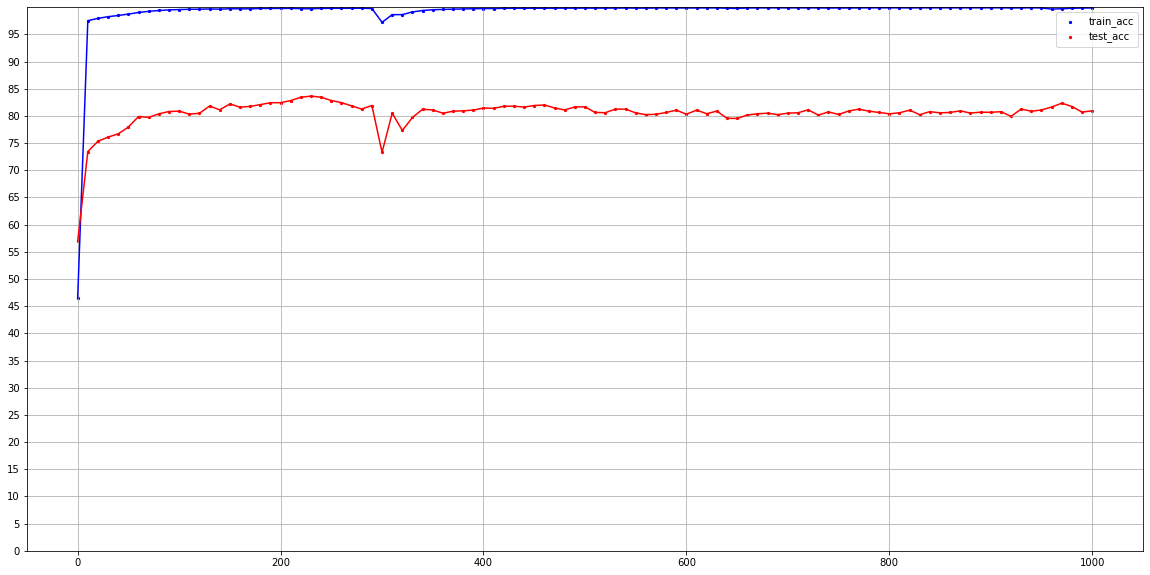

In [16]:
# Draw the learning curve
plt.figure(figsize=(20, 10))
plt.scatter(data=trace, x='epoch', y='train_acc', c="b", s=5)
plt.scatter(data=trace, x='epoch', y='test_acc', c="r", s=5)
plt.plot(trace['epoch'], trace['train_acc'], c="b")
plt.plot(trace['epoch'], trace['test_acc'], c="r")
plt.ylim((0, 100))
plt.yticks(np.arange(0, 100, 5))
plt.grid()
plt.legend()
plt.savefig("learning_curve.eps", format="eps", bbox_inches='tight')

# Loading the best weights and displaying the best model's performances
model.load_state_dict(best_model_weights)
stat_model(model, x_train, y_train, x_test, y_test)

### Save/Load model

In [17]:
torch.save(model.state_dict(), "./model.pytorch")
model.load_state_dict(torch.load("./model.pytorch"))

<All keys matched successfully>

## Adversarial Attacks

### Statistics table

In [18]:
adv_feat_stats = pd.DataFrame(index=df_training.columns[:-1])

adv_results = pd.DataFrame(index=['Accuracy', 
                                  'Mean perturbed features   [Mean L0]', 
                                  'Max perturbed features    [Max  L0]', 
                                  'Mean Euclidiant distance  [Mean L2]', 
                                  'Max Euclidiant distance   [Max  L2]', 
                                  'Mean Maximum perturbation [Mean Li]', 
                                  'Max Maximum perturbation  [Max  Li]'])

adv_inv = pd.DataFrame(index=['Invalid value range',
                              'Invalid binary values',
                              'Invalid class belonging'])

### Lp norms function

In [19]:
def adv_norms(x_test_cpu, adversarial_examples_cpu):
    mean_l0 = np.mean(np.sum(x_test_cpu != adversarial_examples_cpu, axis=1))
    max_l0 = np.max(np.sum(x_test_cpu != adversarial_examples_cpu, axis=1))
    mean_l2 = np.mean(np.sum(np.power(x_test_cpu - adversarial_examples_cpu, 2), axis=1, keepdims=True))
    max_l2 = np.max(np.sum(np.power(x_test_cpu - adversarial_examples_cpu, 2), axis=1, keepdims=True))
    mean_li = np.mean(np.max(np.abs(x_test_cpu - adversarial_examples_cpu), axis=1, keepdims=True))
    max_li = np.max(np.max(np.abs(x_test_cpu - adversarial_examples_cpu), axis=1, keepdims=True))
    return [mean_l0, max_l0, mean_l2, max_l2, mean_li, max_li]

### Invalidity criteria function

In [20]:
def adv_criteria(x_test_cpu, adversarial_examples_cpu):
    # Verify value ranges
    min = x_test_cpu.min(axis=1, keepdims=True)
    max = x_test_cpu.max(axis=1, keepdims=True)
    adv_range = (adversarial_examples_cpu < min) | (adversarial_examples_cpu > max)
    adv_range = adv_range.any(axis=1, keepdims=True)
    adv_range = adv_range.sum(axis=0)

    # Binary values
    binary_feat_ind = list(range(1,85)) + [87, 92, 94, 100, 101]
    adv_bin = adversarial_examples_cpu[:, binary_feat_ind]
    adv_bin = (adv_bin != 1) & ( adv_bin != 0)
    adv_bin = adv_bin.any(axis=1, keepdims=True)
    adv_bin = adv_bin.sum(axis=0)

    # Multi class
    adv1 = adversarial_examples_cpu[:, 1:4] != 0
    adv1 = adv1.astype(int).sum(axis=1, keepdims=True) != 1
    adv1 = adv1.sum(axis=1, keepdims=True)

    adv2 = adversarial_examples_cpu[:, 4:74] != 0
    adv2 = adv2.astype(int).sum(axis=1, keepdims=True) != 1
    adv2 = adv2.sum(axis=1, keepdims=True)

    adv3 = adversarial_examples_cpu[:, 74:85] != 0
    adv3 = adv3.astype(int).sum(axis=1, keepdims=True) != 1
    adv3 = adv3.sum(axis=1, keepdims=True)

    adv_cat = adv1 | adv2 | adv3
    adv_cat = adv_cat.sum(axis=0)

    return [adv_range[0]*100/x_test.shape[0], adv_bin[0]*100/x_test.shape[0], adv_cat[0]*100/x_test.shape[0]]

### Extract attack samples

In [21]:
positive_examples = df_testing[df_testing['42 Labels'] == 1].values
x_test = torch.from_numpy((positive_examples[:, :-1])).float()
y_test = torch.from_numpy((positive_examples[:, -1])).float()
x_test = x_test.to(device)
y_test = y_test.to(device)

### Define the model in ART

In [22]:
# Apply the PyTorch wrapper
classifier = PyTorchClassifier(model=model, loss=criterion, optimizer=optimizer, input_shape=input_size, nb_classes=output_size)

### Clean Data
Unmodified attacks simples from the dataset.

In [23]:
_, predictions_clean = model(x_test, softmax=True).max(dim=1)
accuracy_clean = evaluate(predictions=predictions_clean.long(), real=y_test)

attack='Clean'

# Exporting the clean positive examples in a .csv file
pd.DataFrame(np.hstack((x_test.cpu().numpy(),y_test.cpu().numpy().reshape(y_test.shape[0], 1))), columns=data.columns).to_csv("clean_examples.csv")

x_test_cpu = np.array(x_test.cpu())
adv_results[attack] = [accuracy_clean] + adv_norms(x_test_cpu, x_test_cpu)
adv_inv[attack] = adv_criteria(x_test_cpu, x_test_cpu)

print(adv_results[attack])
print(adv_inv[attack])

Accuracy                               74.207122
Mean perturbed features   [Mean L0]     0.000000
Max perturbed features    [Max  L0]     0.000000
Mean Euclidiant distance  [Mean L2]     0.000000
Max Euclidiant distance   [Max  L2]     0.000000
Mean Maximum perturbation [Mean Li]     0.000000
Max Maximum perturbation  [Max  Li]     0.000000
Name: Clean, dtype: float64
Invalid value range        0.0
Invalid binary values      0.0
Invalid class belonging    0.0
Name: Clean, dtype: float64


### Fast Gradient Sign Method
*Goodfellow et al. (2015) "Explaining and Harnessing Adversarial Examplse"*

In [24]:
# Creating the adversarial examples crafter
adversarial_crafter = FastGradientMethod(classifier,
                                         norm=np.inf,
                                         eps=0.1,
                                         targeted=False,
                                         num_random_init=0,
                                         batch_size=128,
                                         )
# Generating the adversarial examples
adversarial_examples = adversarial_crafter.generate(x=x_test.cpu())

adversarial_examples = torch.from_numpy(adversarial_examples).float()
adversarial_examples = adversarial_examples.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
stat_model(model, x_test, y_test, adversarial_examples, y_test)

adversarial_examples_cpu = np.array(adversarial_examples.cpu())
x_test_cpu = np.array(x_test.cpu())

_, predictions_adv = model(adversarial_examples, softmax=True).max(dim=1)
accuracy_adv = evaluate(predictions=predictions_adv.long(), real=y_test)
attack = 'FGSM'
adv_results[attack] = [accuracy_adv] + adv_norms(x_test_cpu, adversarial_examples_cpu)
adv_inv[attack] = adv_criteria(x_test_cpu, adversarial_examples_cpu)

# Exporting the adversarial examples in a .csv file
pd.DataFrame(np.hstack((adversarial_examples_cpu,y_test.cpu().reshape(y_test.shape[0], 1))), columns=data.columns).to_csv("adversarial_examples_FGSM.csv")

# Saving the statistics in a table
perturbation = np.abs(adversarial_examples_cpu - x_test_cpu)
adv_feat_stats[attack] = ((perturbation > 10e-6).sum(axis=0) / perturbation.shape[0]) * 100

print(adv_results[attack])
print(adv_inv[attack])

Final Training Accuracy: 74.2071%
Final Testing Accuracy : 25.8007%
Classification Report :
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.26      0.41     12833

    accuracy                           0.26     12833
   macro avg       0.50      0.13      0.21     12833
weighted avg       1.00      0.26      0.41     12833



Accuracy                                25.800670
Mean perturbed features   [Mean L0]    120.998909
Max perturbed features    [Max  L0]    121.000000
Mean Euclidiant distance  [Mean L2]      1.209988
Max Euclidiant distance   [Max  L2]      1.209999
Mean Maximum perturbation [Mean Li]      0.100000
Max Maximum perturbation  [Max  Li]      0.100000
Name: FGSM, dtype: float64
Invalid value range        100.0
Invalid binary values      100.0
Invalid class belonging    100.0
Name: FGSM, dtype: float64


### Basic Iterative Method
*Kurakin et al. (2016) "Adversarial examples in the physical world"*

In [25]:
# Creating the adversarial examples crafter
adversarial_crafter = BasicIterativeMethod(classifier, 
                                           eps=0.1, 
                                           eps_step=0.001,
                                           max_iter=100, 
                                           targeted=False, 
                                           batch_size=128)
# Generating the adversarial examples
adversarial_examples = adversarial_crafter.generate(x=x_test.cpu())

adversarial_examples = torch.from_numpy(adversarial_examples).float()
adversarial_examples = adversarial_examples.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
stat_model(model, x_test, y_test, adversarial_examples, y_test)

adversarial_examples_cpu = np.array(adversarial_examples.cpu())
x_test_cpu = np.array(x_test.cpu())

_, predictions_adv = model(adversarial_examples, softmax=True).max(dim=1)
accuracy_adv = evaluate(predictions=predictions_adv.long(), real=y_test)
attack = 'BIM'
adv_results[attack] = [accuracy_adv] + adv_norms(x_test_cpu, adversarial_examples_cpu)
adv_inv[attack] = adv_criteria(x_test_cpu, adversarial_examples_cpu)

# Exporting the adversarial examples in a .csv file
pd.DataFrame(np.hstack((adversarial_examples_cpu,y_test.cpu().reshape(y_test.shape[0], 1))), columns=data.columns).to_csv("adversarial_examples_BIM.csv")

# Saving the statistics in a table
perturbation = np.abs(adversarial_examples_cpu - x_test_cpu)
adv_feat_stats[attack] = ((perturbation > 10e-6).sum(axis=0) / perturbation.shape[0]) * 100

print(adv_results[attack])
print(adv_inv[attack])

PGD - Batches:   0%|          | 0/101 [00:00<?, ?it/s]

Final Training Accuracy: 74.2071%
Final Testing Accuracy : 25.7929%
Classification Report :
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.26      0.41     12833

    accuracy                           0.26     12833
   macro avg       0.50      0.13      0.21     12833
weighted avg       1.00      0.26      0.41     12833



Accuracy                                25.792878
Mean perturbed features   [Mean L0]    120.948570
Max perturbed features    [Max  L0]    121.000000
Mean Euclidiant distance  [Mean L2]      1.016518
Max Euclidiant distance   [Max  L2]      1.178149
Mean Maximum perturbation [Mean Li]      0.100000
Max Maximum perturbation  [Max  Li]      0.100000
Name: BIM, dtype: float64
Invalid value range        100.0
Invalid binary values      100.0
Invalid class belonging    100.0
Name: BIM, dtype: float64


### DeepFool
*Moosavi-Dezfooli et al (2016) "DeepFool: a simple and accurate method to fool deep neural networks"*

In [26]:
# Creating the adversarial examples crafter
adversarial_crafter = DeepFool(classifier, 
                               max_iter=100, 
                               epsilon=1e-6, 
                               nb_grads=10, 
                               batch_size=128)
# Generating the adversarial examples
adversarial_examples = adversarial_crafter.generate(x=x_test.cpu())

adversarial_examples = torch.from_numpy(adversarial_examples).float()
adversarial_examples = adversarial_examples.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
stat_model(model, x_test, y_test, adversarial_examples, y_test)

adversarial_examples_cpu = np.array(adversarial_examples.cpu())
x_test_cpu = np.array(x_test.cpu())

_, predictions_adv = model(adversarial_examples, softmax=True).max(dim=1)
accuracy_adv = evaluate(predictions=predictions_adv.long(), real=y_test)
attack = 'DF'
adv_results[attack] = [accuracy_adv] + adv_norms(x_test_cpu, adversarial_examples_cpu)            
adv_inv[attack] = adv_criteria(x_test_cpu, adversarial_examples_cpu)

# Exporting the adversarial examples in a .csv file
pd.DataFrame(np.hstack((adversarial_examples_cpu,y_test.cpu().reshape(y_test.shape[0], 1))), columns=data.columns).to_csv("adversarial_examples_DF.csv")

# Saving the statistics in a table
perturbation = np.abs(adversarial_examples_cpu - x_test_cpu)
adv_feat_stats[attack] = ((perturbation > 10e-6).sum(axis=0) / perturbation.shape[0]) * 100

print(adv_results[attack])
print(adv_inv[attack])

DeepFool:   0%|          | 0/101 [00:00<?, ?it/s]

Final Training Accuracy: 74.2071%
Final Testing Accuracy : 26.0111%
Classification Report :
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.26      0.41     12833

    accuracy                           0.26     12833
   macro avg       0.50      0.13      0.21     12833
weighted avg       1.00      0.26      0.41     12833



Accuracy                                26.011065
Mean perturbed features   [Mean L0]    120.998442
Max perturbed features    [Max  L0]    121.000000
Mean Euclidiant distance  [Mean L2]      0.025126
Max Euclidiant distance   [Max  L2]      0.150692
Mean Maximum perturbation [Mean Li]      0.051041
Max Maximum perturbation  [Max  Li]      0.158712
Name: DF, dtype: float64
Invalid value range        100.0
Invalid binary values      100.0
Invalid class belonging    100.0
Name: DF, dtype: float64


### Carlini & Wagner L2 Attack
*Carlini et al. (2017) "Towards Evaluating the Robustness of Neural Networks"*

In [27]:
# Creating the adversarial examples crafter
adversarial_crafter = CarliniL2Method(classifier,
                                      confidence=0.0,
                                      targeted=False,
                                      learning_rate=0.01,
                                      binary_search_steps=10,
                                      max_iter=10,
                                      initial_const=0.01,
                                      max_halving=5,
                                      max_doubling=5,
                                      batch_size=128)

# Generating the adversarial examples
adversarial_examples = adversarial_crafter.generate(x=x_test.cpu())

# The transformation to tanh space introduce some small perturbation, we remove it to get the exact statistics
adversarial_examples = pd.DataFrame(adversarial_examples)
adversarial_examples[(np.abs(adversarial_examples - x_test_cpu) < 10e-6)] = x_test_cpu
adversarial_examples = adversarial_examples.values

adversarial_examples = torch.from_numpy(adversarial_examples).float()
adversarial_examples = adversarial_examples.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
stat_model(model, x_test, y_test, adversarial_examples, y_test)

adversarial_examples_cpu = np.array(adversarial_examples.cpu())
x_test_cpu = np.array(x_test.cpu())

_, predictions_adv = model(adversarial_examples, softmax=True).max(dim=1)
accuracy_adv = evaluate(predictions=predictions_adv.long(), real=y_test)
attack = 'CW2'
adv_results[attack] = [accuracy_adv] + adv_norms(x_test_cpu, adversarial_examples_cpu)
adv_inv[attack] = adv_criteria(x_test_cpu, adversarial_examples_cpu)

# Exporting the adversarial examples in a .csv file
pd.DataFrame(np.hstack((adversarial_examples_cpu,y_test.cpu().reshape(y_test.shape[0], 1))), columns=data.columns).to_csv("adversarial_examples_CW2.csv")

# Saving the statistics in a table
perturbation = np.abs(adversarial_examples_cpu - x_test_cpu)
adv_feat_stats[attack] = ((perturbation > 0).sum(axis=0) / perturbation.shape[0]) * 100

print(adv_results[attack])
print(adv_inv[attack])

C&W L_2:   0%|          | 0/101 [00:00<?, ?it/s]

Final Training Accuracy: 74.2071%
Final Testing Accuracy : 24.3045%
Classification Report :
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.24      0.39     12833

    accuracy                           0.24     12833
   macro avg       0.50      0.12      0.20     12833
weighted avg       1.00      0.24      0.39     12833



Accuracy                               24.304527
Mean perturbed features   [Mean L0]    13.854827
Max perturbed features    [Max  L0]    22.000000
Mean Euclidiant distance  [Mean L2]     1.186034
Max Euclidiant distance   [Max  L2]    10.534029
Mean Maximum perturbation [Mean Li]     0.471411
Max Maximum perturbation  [Max  Li]     1.909208
Name: CW2, dtype: float64
Invalid value range         99.3844
Invalid binary values      100.0000
Invalid class belonging      0.0000
Name: CW2, dtype: float64


### Carlini & Wagner L∞ Attack
*Carlini et al. (2017) "Towards Evaluating the Robustness of Neural Networks"*

In [28]:
# Creating the adversarial examples crafter
adversarial_crafter = CarliniLInfMethod(classifier,
                                        confidence=0.0,
                                        targeted=False,
                                        learning_rate=0.01,
                                        max_iter=10,
                                        max_halving=5,
                                        max_doubling=5,
                                        eps=0.1,
                                        batch_size=128)
# Generating the adversarial examples
adversarial_examples = adversarial_crafter.generate(x=x_test.cpu())

# The transformation to tanh space introduce some small perturbation, we remove it to get the exact statistics
adversarial_examples = pd.DataFrame(adversarial_examples)
adversarial_examples[(np.abs(adversarial_examples - x_test_cpu) < 10e-6)] = x_test_cpu
adversarial_examples = adversarial_examples.values

adversarial_examples = torch.from_numpy(adversarial_examples).float()
adversarial_examples = adversarial_examples.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
stat_model(model, x_test, y_test, adversarial_examples, y_test)

adversarial_examples_cpu = np.array(adversarial_examples.cpu())
x_test_cpu = np.array(x_test.cpu())

_, predictions_adv = model(adversarial_examples, softmax=True).max(dim=1)
accuracy_adv = evaluate(predictions=predictions_adv.long(), real=y_test)
attack = 'CW∞'
adv_results[attack] = [accuracy_adv] + adv_norms(x_test_cpu, adversarial_examples_cpu)
adv_inv[attack] = adv_criteria(x_test_cpu, adversarial_examples_cpu)
# Exporting the adversarial examples in a .csv file
pd.DataFrame(np.hstack((adversarial_examples_cpu,y_test.cpu().reshape(y_test.shape[0], 1))), columns=data.columns).to_csv("adversarial_examples_CWi.csv")

# Saving the statistics in a table
perturbation = np.abs(adversarial_examples_cpu - x_test_cpu)
adv_feat_stats[attack] = ((perturbation > 0).sum(axis=0) / perturbation.shape[0]) * 100

print(adv_results[attack])
print(adv_inv[attack])

C&W L_inf:   0%|          | 0/101 [00:00<?, ?it/s]

Final Training Accuracy: 74.2071%
Final Testing Accuracy : 37.5750%
Classification Report :
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.38      0.55     12833

    accuracy                           0.38     12833
   macro avg       0.50      0.19      0.27     12833
weighted avg       1.00      0.38      0.55     12833



Accuracy                               37.575002
Mean perturbed features   [Mean L0]    16.967895
Max perturbed features    [Max  L0]    56.000000
Mean Euclidiant distance  [Mean L2]     0.100136
Max Euclidiant distance   [Max  L2]     0.524530
Mean Maximum perturbation [Mean Li]     0.066327
Max Maximum perturbation  [Max  Li]     0.100000
Name: CW∞, dtype: float64
Invalid value range        73.708408
Invalid binary values      75.469493
Invalid class belonging    28.263072
Name: CW∞, dtype: float64


### Carlini & Wagner L0 Attack
*Carlini et al. (2017) "Towards Evaluating the Robustness of Neural Networks"*

In [29]:
# Creating the adversarial examples crafter
adversarial_crafter = CarliniL0Method(classifier,
                                      confidence=0.0,
                                      targeted=False,
                                      learning_rate=0.01,
                                      binary_search_steps=10,
                                      max_iter=10,
                                      warm_start=False,
                                      initial_const=0.01,
                                      max_halving=5,
                                      max_doubling=5,
                                      batch_size=128)
# Generating the adversarial examples
adversarial_examples = adversarial_crafter.generate(x=x_test.cpu())

adversarial_examples = torch.from_numpy(adversarial_examples).float()
adversarial_examples = adversarial_examples.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
stat_model(model, x_test, y_test, adversarial_examples, y_test)

adversarial_examples_cpu = np.array(adversarial_examples.cpu())
x_test_cpu = np.array(x_test.cpu())

_, predictions_adv = model(adversarial_examples, softmax=True).max(dim=1)
accuracy_adv = evaluate(predictions=predictions_adv.long(), real=y_test)
attack = 'CW0'
adv_results[attack] = [accuracy_adv] + adv_norms(x_test_cpu, adversarial_examples_cpu)
adv_inv[attack] = adv_criteria(x_test_cpu, adversarial_examples_cpu)
# Exporting the adversarial examples in a .csv file
pd.DataFrame(np.hstack((adversarial_examples_cpu,y_test.cpu().reshape(y_test.shape[0], 1))), columns=data.columns).to_csv("adversarial_examples_CW0.csv")

# Saving the statistics in a table
perturbation = np.abs(adversarial_examples_cpu - x_test_cpu)
adv_feat_stats[attack] = ((perturbation > 0).sum(axis=0) / perturbation.shape[0]) * 100

print(adv_results[attack])
print(adv_inv[attack])

Final Training Accuracy: 74.2071%
Final Testing Accuracy : 23.2681%
Classification Report :
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.23      0.38     12833

    accuracy                           0.23     12833
   macro avg       0.50      0.12      0.19     12833
weighted avg       1.00      0.23      0.38     12833



Accuracy                               23.268137
Mean perturbed features   [Mean L0]     3.749084
Max perturbed features    [Max  L0]    19.000000
Mean Euclidiant distance  [Mean L2]     2.288872
Max Euclidiant distance   [Max  L2]    20.155787
Mean Maximum perturbation [Mean Li]     0.858596
Max Maximum perturbation  [Max  Li]     2.490000
Name: CW0, dtype: float64
Invalid value range        70.271955
Invalid binary values      58.014494
Invalid class belonging     0.249357
Name: CW0, dtype: float64


### Jacobian-based Saliency Map Attack
*Papernot et al. (2016) The limitations of deep learning in adversarial settings*

In [30]:
# Creating the adversarial examples crafter
adversarial_crafter = SaliencyMapMethod(classifier,
                                        theta = 0.1,
                                        gamma = 1.0,
                                        batch_size=128)
# Generating the adversarial examples
adversarial_examples = adversarial_crafter.generate(x=x_test.cpu())#, y=np.ones(x_test.shape[0]))

adversarial_examples = torch.from_numpy(adversarial_examples).float()
adversarial_examples = adversarial_examples.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
stat_model(model, x_test, y_test, adversarial_examples, y_test)

adversarial_examples_cpu = np.array(adversarial_examples.cpu())
x_test_cpu = np.array(x_test.cpu())

_, predictions_adv = model(adversarial_examples, softmax=True).max(dim=1)
accuracy_adv = evaluate(predictions=predictions_adv.long(), real=y_test)
attack = 'JSMA'
adv_results[attack] = [accuracy_adv] + adv_norms(x_test_cpu, adversarial_examples_cpu)
adv_inv[attack] = adv_criteria(x_test_cpu, adversarial_examples_cpu)

# Exporting the adversarial examples in a .csv file
pd.DataFrame(np.hstack((adversarial_examples_cpu,y_test.cpu().reshape(y_test.shape[0], 1))), columns=data.columns).to_csv("adversarial_examples_JSMA.csv")

# Saving the statistics in a table
perturbation = np.abs(adversarial_examples_cpu - x_test_cpu)
adv_feat_stats[attack] = ((perturbation > 0).sum(axis=0) / perturbation.shape[0]) * 100

print(adv_results[attack])
print(adv_inv[attack])

JSMA:   0%|          | 0/101 [00:00<?, ?it/s]

Final Training Accuracy: 74.2071%
Final Testing Accuracy : 25.7929%
Classification Report :
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.26      0.41     12833

    accuracy                           0.26     12833
   macro avg       0.50      0.13      0.21     12833
weighted avg       1.00      0.26      0.41     12833



Accuracy                               25.792878
Mean perturbed features   [Mean L0]     2.324788
Max perturbed features    [Max  L0]     5.000000
Mean Euclidiant distance  [Mean L2]     0.077369
Max Euclidiant distance   [Max  L2]     0.420000
Mean Maximum perturbation [Mean Li]     0.186675
Max Maximum perturbation  [Max  Li]     0.500000
Name: JSMA, dtype: float64
Invalid value range         0.007792
Invalid binary values      31.933297
Invalid class belonging    31.029377
Name: JSMA, dtype: float64


### Statistics of the different attack methods

The tables below show for every attack:
- The accuracy of the model and mean/max Lp norms between the original and adversarial examples.
- The pourcentage of examples perturbing each feature.
- The proportion of exemples meeting the different invalidation criteria.

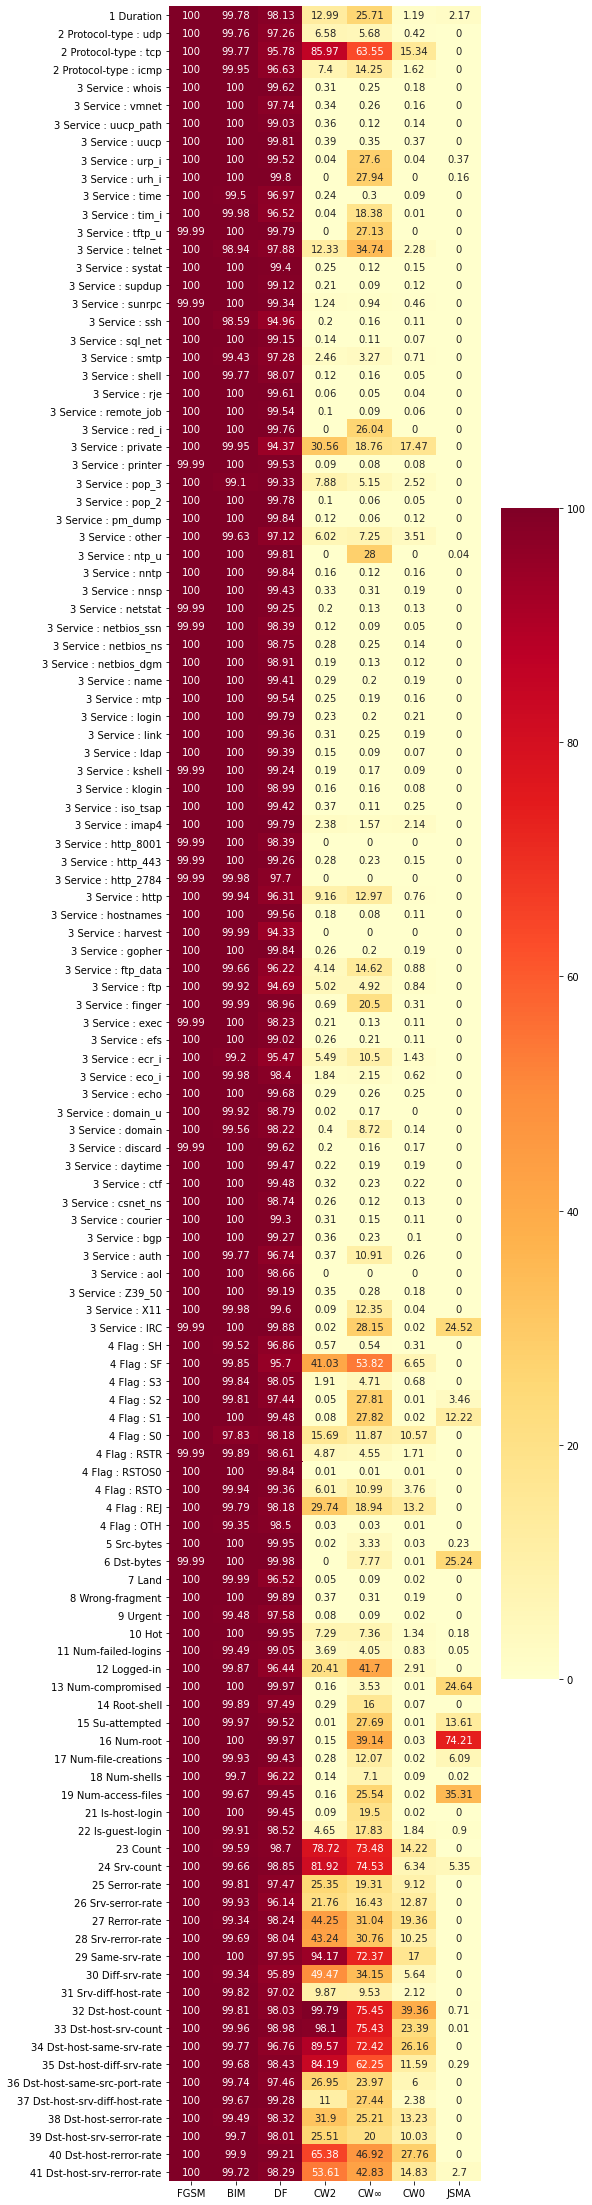

,Clean,FGSM,BIM,DF,CW2,CW∞,CW0,JSMA
Invalid value range,0.0,100.0,100.0,100.0,99.3844,73.708408,70.271955,0.007792
Invalid binary values,0.0,100.0,100.0,100.0,100.0000,75.469493,58.014494,31.933297
Invalid class belonging,0.0,100.0,100.0,100.0,0.0000,28.263072,0.249357,31.029377


In [32]:
adv_results.to_csv("adv_results.csv")
adv_results

adv_feat_stats.to_csv("adv_feat_stats.csv")
adv_feat_stats

fig, ax = plt.subplots(figsize=(7,40))

sb.heatmap(adv_feat_stats.round(decimals=2), annot=True, cmap='YlOrRd', fmt='g')

plt.savefig("hmap_features_stats.eps", format="eps", bbox_inches='tight')
plt.show()

adv_inv.to_csv("./adv_inv")
adv_inv

## Features analysis

### Heat map of the correlation matrix

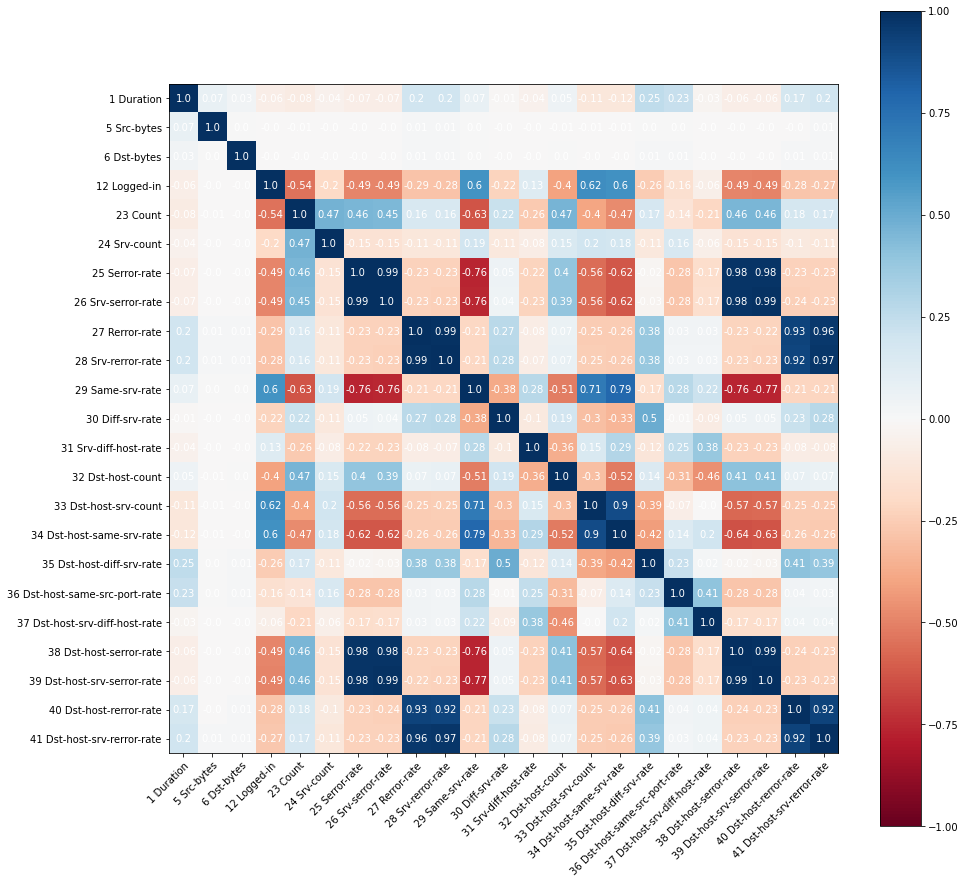

In [33]:
numeric_features =['1 Duration', '5 Src-bytes', '6 Dst-bytes', '12 Logged-in', '23 Count', '24 Srv-count', '25 Serror-rate', '26 Srv-serror-rate', '27 Rerror-rate', '28 Srv-rerror-rate', '29 Same-srv-rate', '30 Diff-srv-rate', '31 Srv-diff-host-rate', '32 Dst-host-count', '33 Dst-host-srv-count', '34 Dst-host-same-srv-rate', '35 Dst-host-diff-srv-rate', '36 Dst-host-same-src-port-rate', '37 Dst-host-srv-diff-host-rate', '38 Dst-host-serror-rate', '39 Dst-host-srv-serror-rate', '40 Dst-host-rerror-rate', '41 Dst-host-srv-rerror-rate']
corr = df_training[numeric_features].corr()

fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(corr, cmap='RdBu', vmin=-1, vmax=1)

ax.figure.colorbar(im)
plt.yticks(np.arange(0, len(corr.columns), 1), corr.columns)
plt.xticks(np.arange(0, len(corr.columns), 1), corr.columns, rotation=45, ha="right", rotation_mode="anchor")

for i in range(len(numeric_features)):
    for j in range(len(numeric_features)):
        text = ax.text(j, i, corr.iloc[i, j].round(decimals=2), ha="center", va="center", color="w")
        
plt.savefig('correlation_matrix.eps', format='eps', bbox_inches='tight')  
plt.show()